In [89]:
import calendar
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import pandas as pd
import numpy as np
import requests
from urllib.parse import unquote 
from bs4 import BeautifulSoup as bs


In [2]:
def get_etf():
    etf_csv=pd.read_csv('Developed Asia Pacific ETF List (108).csv')
    symbol=etf_csv['Symbol']
    inception=etf_csv['Inception']
    count=0
    real_symbol=[]
    in_s=[]
    for candiate in inception:
        s=datetime.datetime.strptime(candiate, "%d/%m/%Y")
        if s<=datetime.datetime.strptime("31/12/2015", "%d/%m/%Y"):
           # print(s.strftime("%d/%m/%Y"))
            in_s.append(s.strftime("%d/%m/%Y"))
            real_symbol.append(symbol[count])
        count=count+1
    return real_symbol

In [3]:
def get_url(etf):
    url=[]  
    url.append("https://www.moneydj.com/ETF/X/xdjbcd/Basic0003BCD.xdjbcd?etfid="+etf+"&b=2015-12-31&c=2018-12-31")
    return url

In [96]:
def get_SID(etf):
    SIDList=[]
    url = 'http://mschart.morningstar.com/chartweb/defaultChart'
    data ={"type":"gettid",
               "symbol":"ARCX%3A"+etf+"%2C",
               "region":"usa",
               "ifmt":"0",
               "callback":
               "jQuery16404257182418483476_1552564606341",
               "fbclid":"IwAR3nDY3tKOiMUpfM5D3v_60juu-jN6QXy7uKwlt6faLPHTRUp7p4Tv6_iTo",
              }
    data['symbol'] = unquote(data['symbol'])
    response_data  = requests.post(url,params = data)
    print (response_data.url)
    print (response_data.text)
    

In [4]:
start_date="2015-12-31"
end_date="2018-12-31"
start = datetime.datetime.strptime(start_date, "%Y-%m-%d") # datetime.strptime(date_string, format) return datetime
stop = datetime.datetime.strptime(end_date, "%Y-%m-%d")

In [5]:
def get_date(url):
    res = requests.get(url) 
    doc = bs(res.text, 'lxml')
    data = doc.select_one('p').get_text()
    datas=data.split(' ',1)
    date=datas[0]
    date=date.split(',')
    days=[] #csv裡面的date
    for day in date:
        day=datetime.datetime.strptime(day, "%Y%m%d")
        days.append(day)
    end_day=[] #月底
    for i in range(len(days)-1):
        beforeday=days[i]
        nextday=days[i+1]
        if (beforeday.year and beforeday.month)!=(nextday.year and nextday.month):
            end_day.append(beforeday.strftime("%Y/%m/%d"))
    end_day.append(days[len(days)-1].strftime("%Y/%m/%d"))# last day
    return end_day

In [6]:
def get_nav(url):
    res = requests.get(url) 
    doc = bs(res.text, 'lxml')
    data = doc.select_one('p').get_text()
    datas=data.split(' ',1)
    date=datas[0]
    date=date.split(',')
    days=[] #csv裡面的date
    for day in date:
        day=datetime.datetime.strptime(day, "%Y%m%d")
        days.append(day)
    end_day=[] #月底
    for i in range(len(days)-1):
        beforeday=days[i]
        nextday=days[i+1]
        if (beforeday.year and beforeday.month)!=(nextday.year and nextday.month):
            end_day.append(beforeday.strftime("%Y%m%d"))
    end_day.append(days[len(days)-1].strftime("%Y%m%d"))# last day
#     print(end_day[36])
#     print(len(end_day))
    value=datas[1].replace(' ',',')
    value=value.split(',')
    v1=value[0:755]
    index=[]
    nav=[]
    for i in range(0,37):
#         print(end_day[i])
        count=0
        for   cday in date:
            if end_day[i]==cday:
                index.append(count)
                nav.append(float(v1[count]))
            count=count+1
#     print(index)
#     print(nav)
    return nav
    

In [7]:
# end_day,nav=get_nav("https://www.moneydj.com/ETF/X/xdjbcd/Basic0003BCD.xdjbcd?etfid=EWY&b=2015-12-31&c=2018-12-31")

In [97]:
dict={}
etfs=get_etf()
etfs.remove('JPIN')
etfs.remove('GSIE')
etfs.remove('IDOG')
etfs.remove('IDLB')
etfs.remove('IVAL')
etfs.remove('IMOM')
etfs.remove('PAF')
etfs.remove('DDBI')
dict['date']=get_date('https://www.moneydj.com/ETF/X/xdjbcd/Basic0003BCD.xdjbcd?etfid=EWY&b=2015-12-31&c=2018-12-31')
print(dict)
for etf in etfs:
    get_SID(etf)
    url=get_url(etf)
    print(etf)
    dict[etf]=get_nav(url[0])
print('done')

{'date': ['2015/12/31', '2016/01/29', '2016/02/29', '2016/03/31', '2016/04/29', '2016/05/31', '2016/06/30', '2016/07/29', '2016/08/31', '2016/09/30', '2016/10/31', '2016/11/30', '2016/12/30', '2017/01/31', '2017/02/28', '2017/03/31', '2017/04/28', '2017/05/31', '2017/06/30', '2017/07/31', '2017/08/31', '2017/09/29', '2017/10/31', '2017/11/30', '2017/12/29', '2018/01/31', '2018/02/28', '2018/03/29', '2018/04/30', '2018/05/31', '2018/06/29', '2018/07/31', '2018/08/31', '2018/09/28', '2018/10/31', '2018/11/30', '2018/12/31']}
http://mschart.morningstar.com/chartweb/defaultChart?type=gettid&symbol=ARCX%3AEWJ%2C&region=usa&ifmt=0&callback=jQuery16404257182418483476_1552564606341&fbclid=IwAR3nDY3tKOiMUpfM5D3v_60juu-jN6QXy7uKwlt6faLPHTRUp7p4Tv6_iTo

EWJ
http://mschart.morningstar.com/chartweb/defaultChart?type=gettid&symbol=ARCX%3AEWY%2C&region=usa&ifmt=0&callback=jQuery16404257182418483476_1552564606341&fbclid=IwAR3nDY3tKOiMUpfM5D3v_60juu-jN6QXy7uKwlt6faLPHTRUp7p4Tv6_iTo

EWY
http://mschart.

KeyboardInterrupt: 

In [92]:
data=pd.DataFrame(dict)
data

,date,EWJ
0,2015/12/31,49.12
1,2016/01/29,45.07
2,2016/02/29,43.78
3,2016/03/31,45.86
4,2016/04/29,47.97
5,2016/05/31,47.47
6,2016/06/30,45.92
7,2016/07/29,48.90
8,2016/08/31,49.05
9,2016/09/30,49.82


In [92]:
data.to_csv(r'./nav.csv',index=False,sep=',')

In [93]:
import matplotlib.pyplot as plt

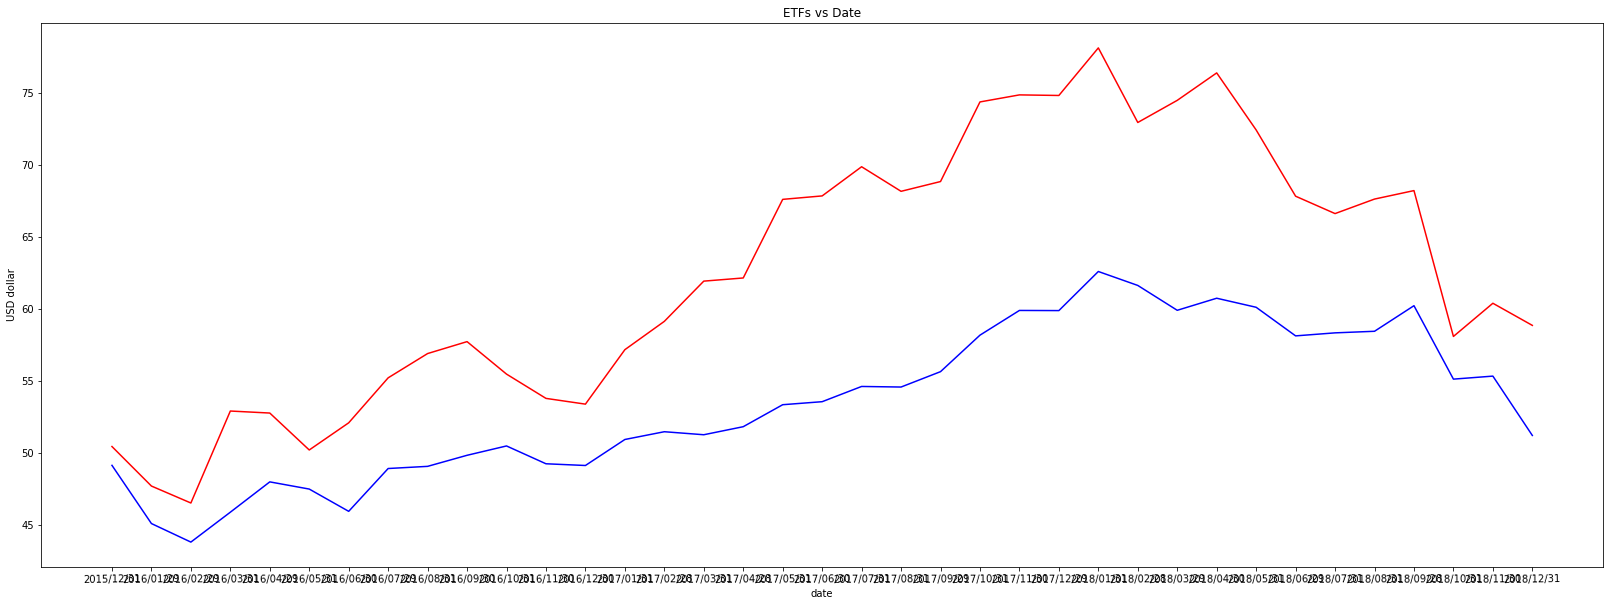

In [104]:
plt.figure(figsize=(28,10))
plt.title('ETFs vs Date')
plt.xlabel('date')
plt.ylabel('USD dollar')
plt.plot(dict['date'], dict['EWJ'],'b',label='EWJ')
plt.plot(dict['date'], dict['EWY'],'r',label='EWY')
plt.xticks(dict['date'], dict['date'], rotation=1)
plt.show()